# Importação de Bibliotecas

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from utils.functions import forward_selection, backward_selection_aic,stepwise_selection_both,backward_selection_pvalue
from sklearn.metrics import mean_squared_error
from scipy.stats import shapiro

# Importação das bases de dados

In [68]:
df = pd.read_csv(r'Bodyfat.csv')
df = df.drop(columns=['Density'])
df.head()

,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


# Objetivo da análise

Criar um modelo de regressão linear para prever o nível de gordura corporal dos pacientes da clínica baseado nas medidas corporais coletadas dos pacientes.

# Compreensão do negocio

A base de dados contém 14 colunas númericas e 251 registros de pacientes

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bodyfat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


# Analise Exploratoria dos Dados

Entender o que tem dentro da tabela.
missing, outliers, distribuição das variaveis, simetria, assimetria, normalidade, etc.

print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

for column in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribuição de {column}')
    plt.show()

In [70]:
df.describe()

,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [71]:
df.isnull().sum()

bodyfat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

In [72]:
df.duplicated().sum()

0

Na analise descritiva da base de dados percebe-se que os dados foram registrados corretamente.
Não há valores nulos e nem duplicados.
Também não foi identificado outliers que possam impactar no modelo.

# Analises Estatisticas

In [73]:
df.columns

Index(['bodyfat', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip',
       'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist'],
      dtype='object')

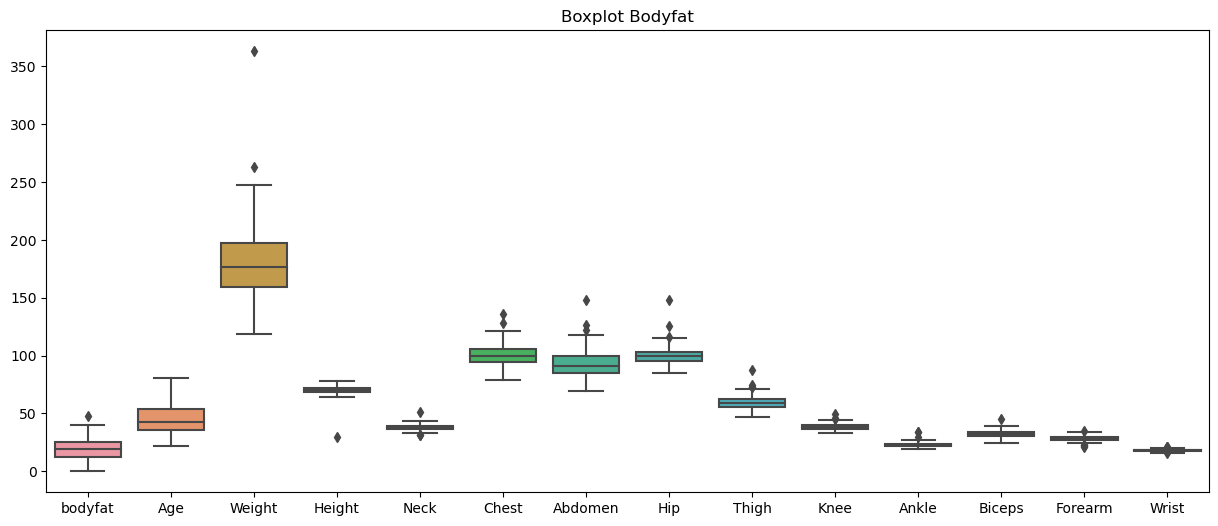

In [98]:
# Ajustar o tamanho da figura
plt.figure(figsize=(15, 6))

# Criar o boxplot para várias colunas
sns.boxplot(data=df)  # Isso cria boxplots para todas as colunas numéricas

# Adicionar título
plt.title('Boxplot Bodyfat')

# Exibir o gráfico
plt.show()

Na analise do gráfico de boxplot percebe-se que não há outliers que possam comprometer a analise e a elaboracao do modelo.

# Analise bivariada

Foco na multicolinearidade, VIF, correlações e escolhas de variaveis.


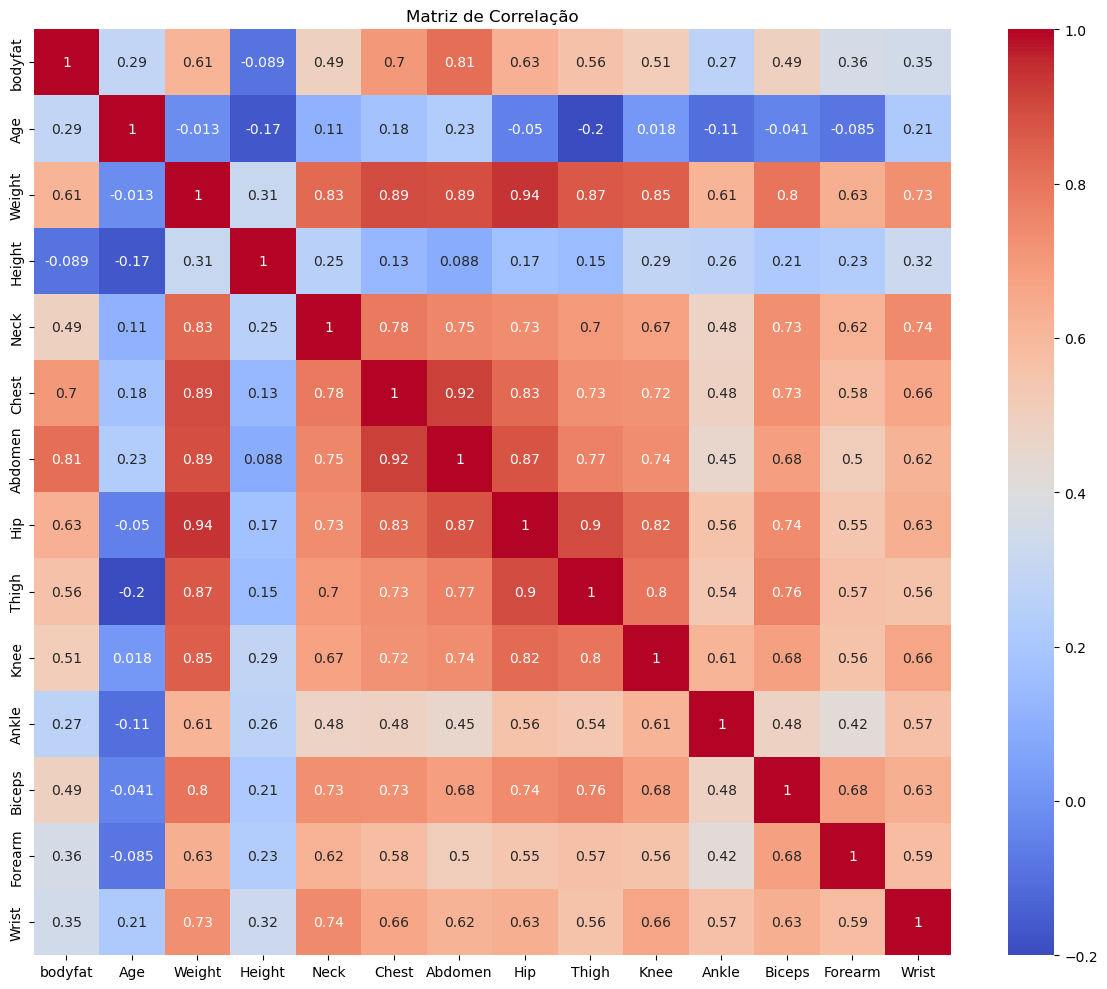

In [75]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 10})

plt.title('Matriz de Correlação')

plt.tight_layout()
plt.show()

No gráfico de correlação percebe-se algumas variáves com forte correlação entre elas.
Para uma analise mais robusta, deve-se fazer o cálculo do VIF (Variance Inflation Factor)

Calculo do VIF

In [76]:
# 2. Separe as colunas independentes (X) e remova 'y'
X = df.drop(columns='bodyfat')

# 3. Adicione a constante (intercepto) para o modelo
X = sm.add_constant(X)

# 4. Calcule o VIF para cada coluna (incluindo 'const')
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i)  
    for i in range(X.shape[1])
]

# 5. Calcule a Tolerância = 1 / VIF
vif_data["Tolerance"] = 1 / vif_data["VIF"]

# 6. Visualize o resultado
print(vif_data)

   Variable          VIF  Tolerance
0     const  4091.885819   0.000244
1       Age     2.250450   0.444356
2    Weight    33.509320   0.029842
3    Height     1.674591   0.597161
4      Neck     4.324463   0.231243
5     Chest     9.460877   0.105698
6   Abdomen    11.767073   0.084983
7       Hip    14.796520   0.067583
8     Thigh     7.777865   0.128570
9      Knee     4.612147   0.216819
10    Ankle     1.907961   0.524120
11   Biceps     3.619744   0.276263
12  Forearm     2.192492   0.456102
13    Wrist     3.377515   0.296076


# Analise de Multicolinearidade

A analise do VIF sugere a exclusão das colunas que tiveram VIF > 5, mas não necessariamente todas nessa condição.
Para uma analise mais robusta, foi feita a simulação de varios modelos, com e sem as variaveis com alto VIF

# Modelo

In [77]:
features = df.columns.drop(['bodyfat'])
formula = 'bodyfat ~' + '+'.join(features)
reg_mult = smf.ols(formula=formula,data=df).fit()
print(reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           7.72e-64
Time:                        18:26:03   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.1885     17.349     -1.048      0.2

Esse modelo foi elaborado sem considerar o calculo do VIF. 
O modelo tem variaveis com poder preditivo, porém com grande multicolinearidade devido ao alto número de cond.no. e, também, conforme verificado no calculo do VIF das variaveis.

In [78]:
#df_vif= ['Age','Height','Neck','Knee','Ankle','Biceps','Forearm','Wrist']
features = df.columns.drop(['bodyfat','Chest','Hip','Knee'])
formula = 'bodyfat ~' + '+'.join(features)
reg_mult_vif = smf.ols(formula=formula,data=df).fit()
print(reg_mult_vif.summary())


                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     71.13
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           3.72e-66
Time:                        18:26:03   Log-Likelihood:                -719.32
No. Observations:                 252   AIC:                             1461.
Df Residuals:                     241   BIC:                             1499.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.9812     11.978     -2.754      0.0

Somente tirar as variaveis com alto VIF não foi o suficiente, pois o modelo piorou o r2 e ainda assim ficou com multicolinearidade.

Após as analises do VIF e a correlação entre as variaveis, optou por excluir as variaveis ['Chest','Hip','Knee']

# Seleção Forward

In [79]:
df_vif = df.drop(columns=['Chest','Hip','Knee'])
df_vif.head()

,bodyfat,Age,Weight,Height,Neck,Abdomen,Thigh,Ankle,Biceps,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,85.2,59.0,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,83.0,58.7,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,87.9,59.6,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,86.4,60.1,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,100.0,63.2,24.0,32.2,27.7,17.7


In [80]:
forward_model, forward_vars = forward_selection(df_vif, response='bodyfat', significance_level=0.05)

print(forward_model.summary())
print("\nVariáveis selecionadas:", forward_vars)

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     171.3
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           5.39e-70
Time:                        18:26:03   Log-Likelihood:                -725.11
No. Observations:                 252   AIC:                             1460.
Df Residuals:                     247   BIC:                             1478.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.8541      7.245     -4.811      0.0

# Seleção Backward

In [81]:
# Ajusta o modelo por backward com critério AIC
backward_model, final_vars = backward_selection_aic(df_vif, response='bodyfat')

# Sumário do modelo final
print(backward_model.summary())

# Quais variáveis ficaram?
print("Variáveis no modelo final:", final_vars)

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     101.6
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           1.26e-68
Time:                        18:26:04   Log-Likelihood:                -720.53
No. Observations:                 252   AIC:                             1457.
Df Residuals:                     244   BIC:                             1485.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -33.2580      9.007     -3.693      0.0

# Seleção both

In [82]:
both_model, final_vars = stepwise_selection_both(
    data=df_vif, 
    response='bodyfat',
    initial_list=None,       # ou alguma lista inicial de variáveis
    threshold_in=0.01,       # p-value threshold para incluir
    threshold_out=0.05,      # p-value threshold para remover
    verbose=True
)

print(both_model.summary())
print("Variáveis selecionadas:", final_vars)

 + Include Abdomen with p-value 0.0000, AIC = 1515.79
 + Include Weight with p-value 0.0000, AIC = 1471.18
 + Include Wrist with p-value 0.0047, AIC = 1465.04
 + Include Forearm with p-value 0.0098, AIC = 1460.22
No further improvement.
                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     171.3
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           5.39e-70
Time:                        18:26:04   Log-Likelihood:                -725.11
No. Observations:                 252   AIC:                             1460.
Df Residuals:                     247   BIC:                             1478.
Df Model:                           4                                         
Covariance Type:            nonrobust               

# Seleção p_value

In [83]:
pvalue_model, final_vars = backward_selection_pvalue(df_vif, response='bodyfat', alpha=0.05, verbose=True)

print(pvalue_model.summary())
print("Variáveis remanescentes:", final_vars)


Removendo 'Height' (p-value = 0.6970)
Removendo 'Ankle' (p-value = 0.3739)
Removendo 'Biceps' (p-value = 0.2401)
Removendo 'Neck' (p-value = 0.0684)
Removendo 'Thigh' (p-value = 0.0600)
Removendo 'Age' (p-value = 0.1542)
                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     171.3
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           5.39e-70
Time:                        18:26:04   Log-Likelihood:                -725.11
No. Observations:                 252   AIC:                             1460.
Df Residuals:                     247   BIC:                             1478.
Df Model:                           4                                         
Covariance Type:            nonrobust                               

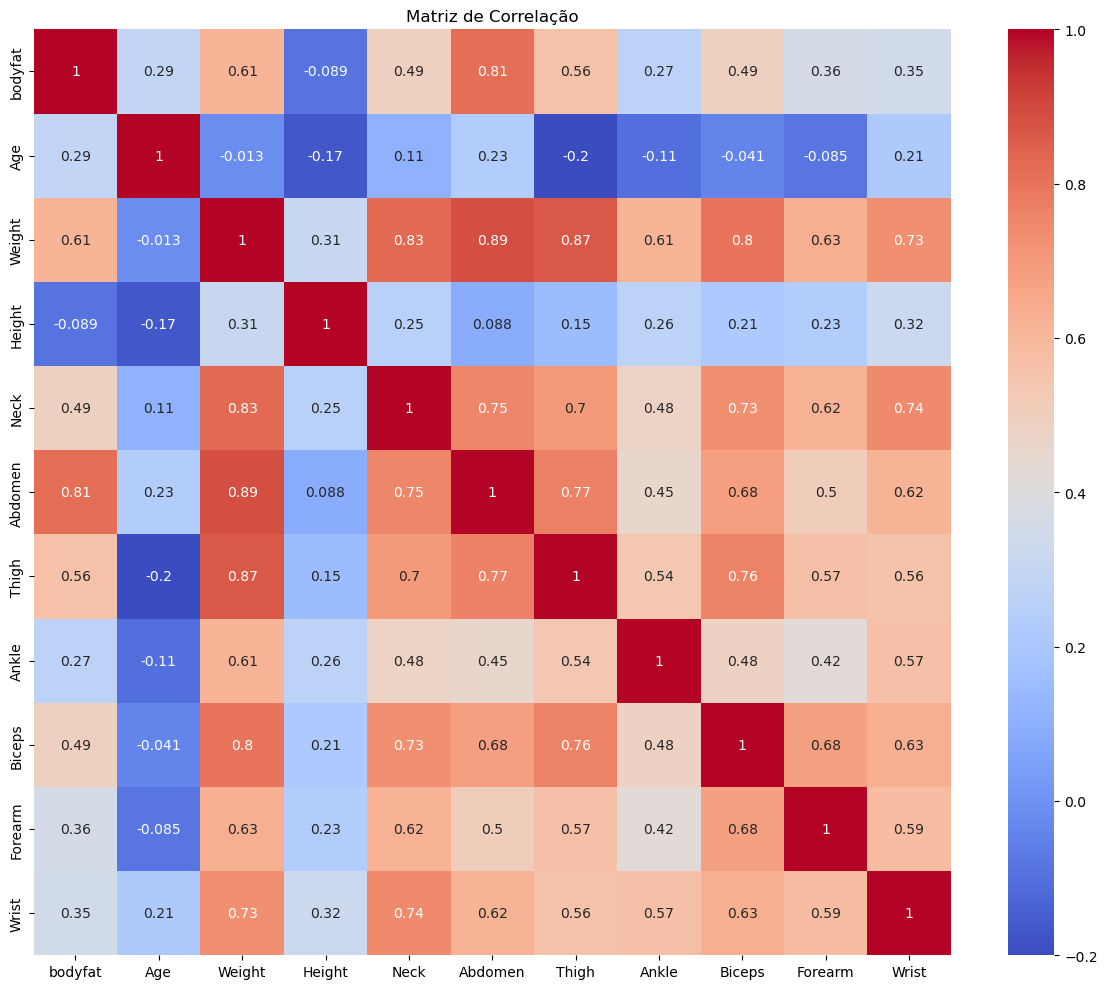

In [84]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_vif.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 10})

plt.title('Matriz de Correlação')

plt.tight_layout()
plt.show()

In [95]:
df_vif['p_value'] = pvalue_model.predict(df_vif)
df_vif['backward'] = backward_model.predict(df_vif)
df_vif['both'] = both_model.predict(df_vif)
df_vif['forward'] = forward_model.predict(df_vif)
df_vif['residuos'] = df_vif['bodyfat'] - df_vif['forward']

In [96]:
df_vif.head()

,bodyfat,Age,Weight,Height,Neck,Abdomen,Thigh,Ankle,Biceps,Forearm,Wrist,p_value,backward,both,forward,residuals,residuos
0,12.3,23,154.25,67.75,36.2,85.2,59.0,21.9,32.0,27.4,17.1,16.275917,15.519872,16.275917,16.275917,-3.219872,-3.975917
1,6.1,22,173.25,72.25,38.5,83.0,58.7,23.4,30.5,28.9,18.2,10.561541,9.311724,10.561541,10.561541,-3.211724,-4.461541
2,25.3,22,154.00,66.25,34.0,87.9,59.6,24.0,28.8,25.2,16.6,18.710692,18.530690,18.710692,18.710692,6.769310,6.589308
3,10.4,26,184.75,72.25,37.4,86.4,60.1,22.8,32.4,29.4,18.2,12.623798,12.363126,12.623798,12.623798,-1.963126,-2.223798
4,28.7,24,184.25,71.25,34.4,100.0,63.2,24.0,32.2,27.7,17.7,26.182635,26.495096,26.182635,26.182635,2.204904,2.517365


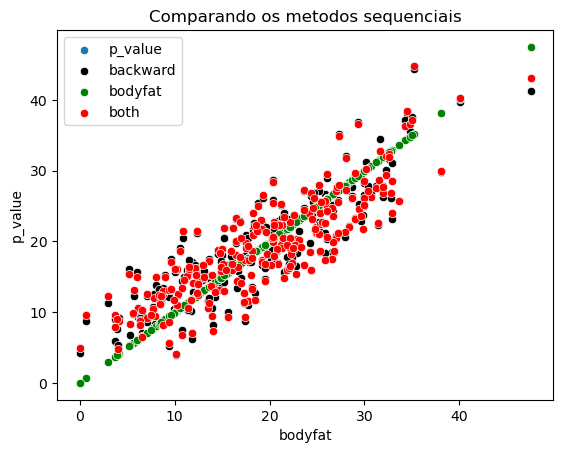

In [87]:
fig, ax = plt.subplots()
sns.scatterplot(data=df_vif,x=df_vif['bodyfat'],y=df_vif['p_value'],ax=ax, label='p_value')
sns.scatterplot(data=df_vif,x=df_vif['bodyfat'],y=df_vif['backward'],ax=ax, label='backward',color='black')
sns.scatterplot(data=df_vif,x=df_vif['bodyfat'],y=df_vif['bodyfat'],ax=ax, label='bodyfat',color='green')
sns.scatterplot(data=df_vif,x=df_vif['bodyfat'],y=df_vif['both'],ax=ax, label='both',color='red')

plt.title("Comparando os metodos sequenciais")
plt.show()

# Calculando RMSE

In [88]:

mse_forward = mean_squared_error(
    df_vif['bodyfat'], 
    df_vif['forward'], 
    )
print("RMSE - forward:", np.sqrt(mse_forward))


mse_backward = mean_squared_error(
    df_vif['bodyfat'], 
    df_vif['backward']
)
print("RMSE - backward:", np.sqrt(mse_backward))

mse_both = mean_squared_error(
    df_vif['bodyfat'], 
    df_vif['both']
)
print("RMSE - both:", np.sqrt(mse_both))

mse_pvalue = mean_squared_error(
    df_vif['bodyfat'], 
    df_vif['p_value']
)
print("RMSE - pvalue:", np.sqrt(mse_pvalue))

RMSE - forward: 4.2994258417856015
RMSE - backward: 4.221942216494447
RMSE - both: 4.2994258417856015
RMSE - pvalue: 4.299425841785601


# Analise de residuos

4 Regras;
1) O erro é uma variável aleatoria com media zero;
2) A variancia do erro, designado por sigma2, é identica para todos os valores das variaveis independentes, ou seja, a variancia e constante;
3) Os valores de E são independentes - não deve ter um padrão;
4) O erro é uma variavel aleatoria com distribuicao normal refletindo o desvio entre y e y^

Se alguma regra for quebrada, o meu modelo não funcionara e devera ser reavaliado

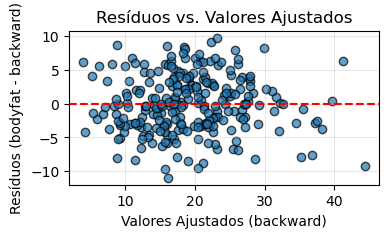

<Figure size 400x200 with 0 Axes>

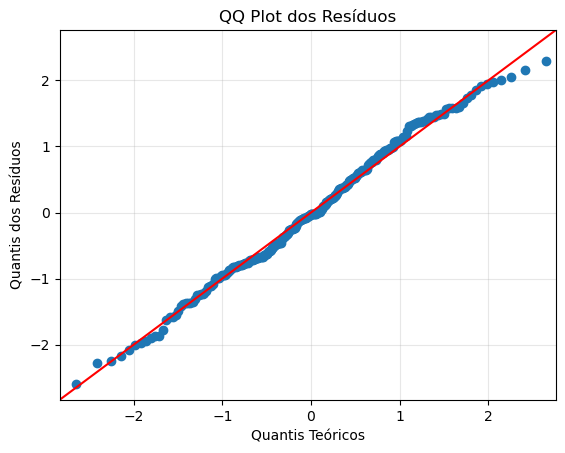

In [90]:
# Calculando os resíduos e valores ajustados
df_vif['residuals'] = df_vif['bodyfat'] - df_vif['backward']  # Resíduos: Observado - Predito
valores_ajustados = df_vif['backward']               # Valores ajustados
residuos = df_vif['residuals']                     # Resíduos

# Gráfico 1: Resíduos vs. Valores Ajustados
plt.figure(figsize=(4, 2))
plt.scatter(valores_ajustados, residuos, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
plt.title("Resíduos vs. Valores Ajustados")
plt.xlabel("Valores Ajustados (backward)")
plt.ylabel("Resíduos (bodyfat - backward)")
plt.grid(alpha=0.3)
plt.show()

# Gráfico 2: QQ Plot dos Resíduos
plt.figure(figsize=(4, 2))
sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ Plot dos Resíduos")
plt.ylabel("Quantis dos Resíduos")
plt.xlabel("Quantis Teóricos")
plt.grid(alpha=0.3)
plt.show()

In [94]:
# Teste de normalidade dos resíduos
residuos = df_vif['residuals'] 
#Aplicando o teste de Shapiro-Wilk 
stat, p_value = shapiro(residuos) 
# Exibindo os resultados 
print(f"Estatística do teste: {stat}") 
print(f"P-valor: {p_value}") 

Estatística do teste: 0.991460919380188
P-valor: 0.15048156678676605


In [97]:
df_vif['residuos'].mean()

1.510819688050221e-13

# Conclusão

Considerando os pontos relacionados abaixo, o modelo escolhido foi o backward:
- R2 ajustado foi de 0,737 - com 7 variavies no modelo - mediante 0,731 dos demais modelos;
- As variaveis escolhidas pelo modelo tem poder preditivo, considerando o Prob (F-statistic): 1.26e-6;
- É o modelo que teve menor RMSE - 4,22 mediante 4,29 nos demais modelos;
- A analise dos residuos segue uma distribuição normal e a média é zero.